In [49]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.spatial import procrustes
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [50]:
# TODO: outlier detection and removal
# TODO: run all subjects
# TODO: plot racket plane over trajectory
# TODO: think about rotation..
# TODO: efficient trajectory data structure (stop refetching them each time..)

In [51]:
data_path = "C:\\Users\\flipe\\AppData\\LocalLow\\Warehouse\\VR-tennis\\Data"
subject_paths = [f.name for f in os.scandir(data_path) if f.is_dir()]
subject_count = len(subject_paths)

### Subject selection

In [52]:
subject2plot = "Manel"

### Feature selection

In [53]:
features2compare = [
    "centereyeanchor",
    "lefthandanchor",
    "racket-grip-base",
    "racket-stringbed-center",
    "ball-tracker",
]
features2compare_labels = ["head", "left-hand", "grip", "strings", "ball"]
feature_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
num_features = len(features2compare)

### Alignment window

In [54]:
alignment = "RacketHit"
window_duration = 0.5  # seconds
half_window_duration = window_duration / 2
window_size = int(window_duration * 500) + 1

### General settings

In [55]:
useHeadCentricDriftCorrection = True

### Load data

In [56]:
# List CSV files in each subject directory
for subject in subject_paths:
    subject_dir = os.path.join(data_path, subject)
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith(".csv")]
    print(f"Subject: {subject}")
    print("CSV files:", csv_files)
    print("-" * 40)

# Find the subject directory that matches subject2plot
subject_dir_match = [s for s in subject_paths if subject2plot in s]
if subject_dir_match:
    subject_dir = os.path.join(data_path, subject_dir_match[0])
    csv_files = [f for f in os.listdir(subject_dir) if f.endswith(".csv")]
    dfs_features = {}
    for feature in features2compare:
        csv_to_read = [f for f in csv_files if feature in f]
        if csv_to_read:
            csv_path = os.path.join(subject_dir, csv_to_read[0])
            label = features2compare_labels[features2compare.index(feature)]
            dfs_features[label] = pd.read_csv(csv_path)
            dfs_features[label]["position.x"] *= -1
            print(f"Loaded {csv_to_read[0]} for subject {subject2plot}")
            print(dfs_features[label].head())
        else:
            print(f"No CSV file found for feature: {feature} in subject {subject2plot}")
else:
    print(f"No subject directory found for: {subject2plot}")

Subject: Charline_R_vr3_3_2025-06-23_15-12-35
CSV files: ['name_age_sex_tennis-exp_vr-exp_ball-tracker.csv', 'name_age_sex_tennis-exp_vr-exp_centereyeanchor.csv', 'name_age_sex_tennis-exp_vr-exp_lefthandanchor.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-left.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-right.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-top.csv', 'name_age_sex_tennis-exp_vr-exp_racket-grip-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-stringbed-center.csv', 'name_age_sex_tennis-exp_vr-exp_righthandanchor.csv']
----------------------------------------
Subject: FilipeMendes_R_vr8_4_2025-06-24_11-07-13
CSV files: ['name_age_sex_tennis-exp_vr-exp_ball-tracker.csv', 'name_age_sex_tennis-exp_vr-exp_centereyeanchor.csv', 'name_age_sex_tennis-exp_vr-exp_lefthandanchor.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-base.csv', 'name_age_sex_tennis-exp_vr-exp_racket-frame-left.csv', 'name_age_sex_te

### Parse task stage data

In [57]:
# Determine the number of unique stages present in the data
all_stages = set()
for label in dfs_features:
    if "stage" in dfs_features[label].columns:
        all_stages.update(dfs_features[label]["stage"].dropna().unique())

unique_stages = sorted(list(all_stages))
num_stages = len(unique_stages)
print(f"Unique stages: {unique_stages}")
print(f"Number of unique stages: {num_stages}")

Unique stages: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Number of unique stages: 4


### Time selection

In [58]:
time2exclude = 60

# Exclude data before a certain time for both features in dfs_features
for label in dfs_features:
    mask = dfs_features[label]["time"] >= time2exclude
    dfs_features[label].loc[
        ~mask, dfs_features[label].columns.difference(["time"])
    ] = np.nan

### Plot raw position data

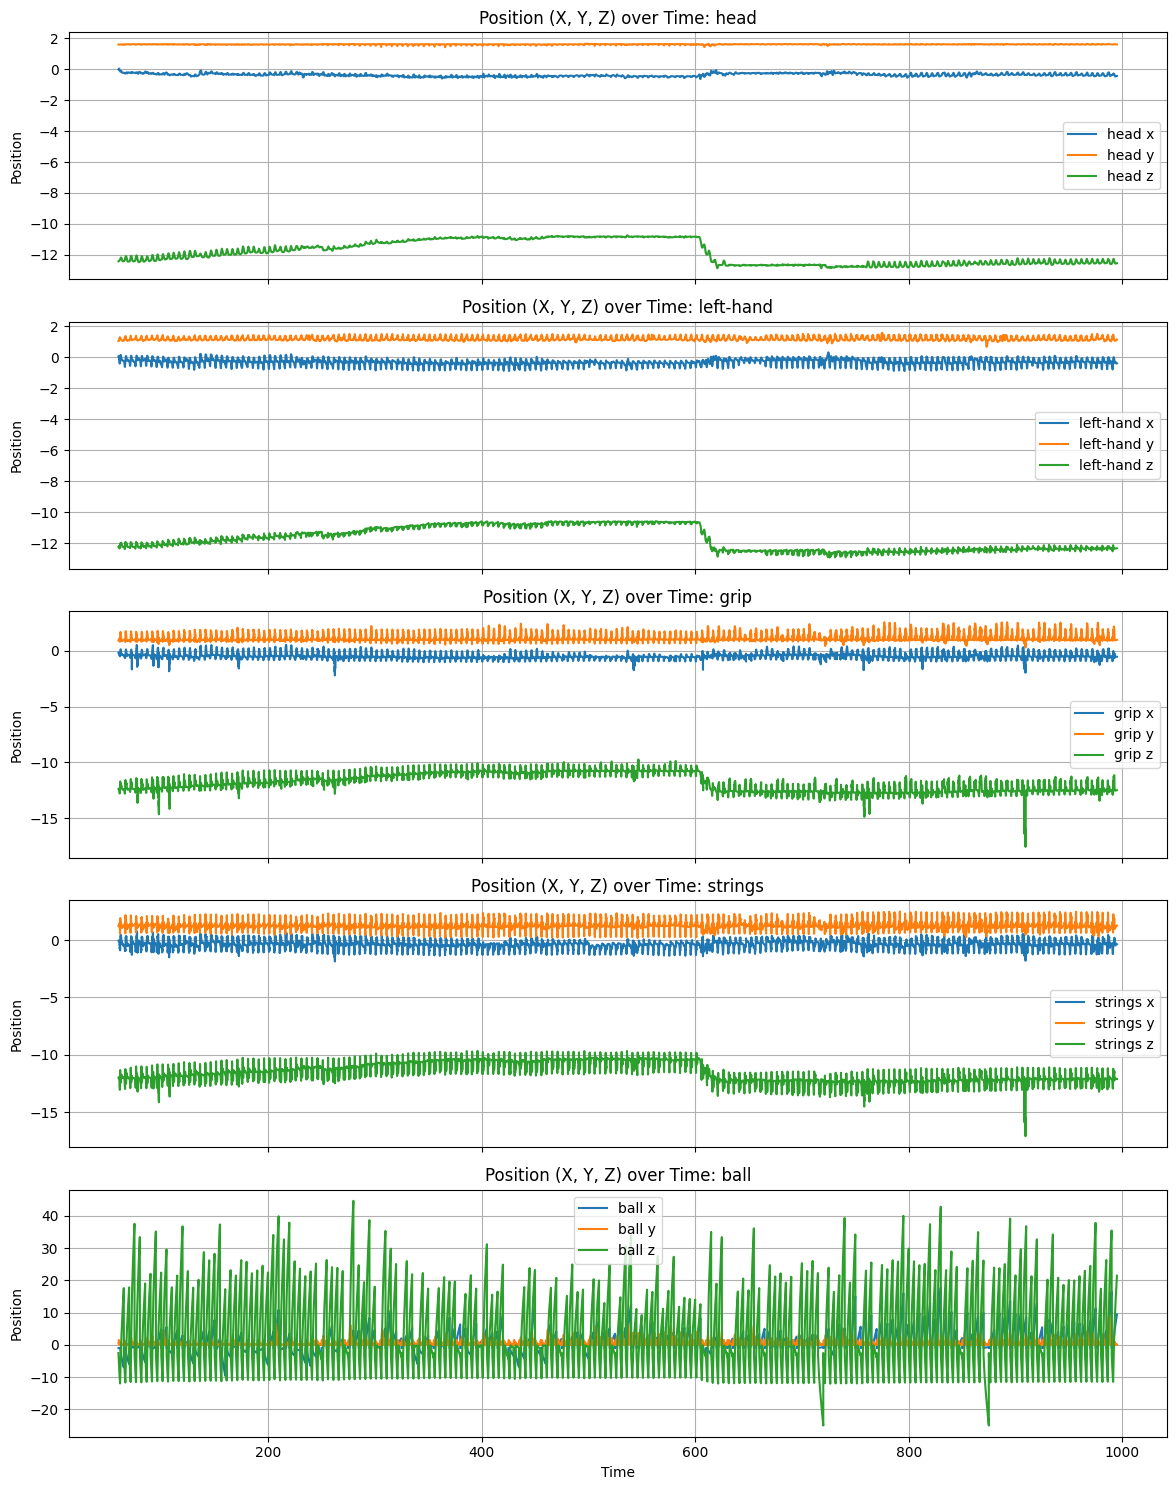

In [59]:
fig, axs = plt.subplots(num_features, 1, figsize=(12, 15), sharex=True)

for i, label in enumerate(dfs_features):
    df = dfs_features[label]
    axs[i].plot(df["time"], df["position.x"], label=f"{label} x")
    axs[i].plot(df["time"], df["position.y"], label=f"{label} y")
    axs[i].plot(df["time"], df["position.z"], label=f"{label} z")
    axs[i].set_ylabel("Position")
    axs[i].set_title(f"Position (X, Y, Z) over Time: {label}")
    axs[i].legend()
    axs[i].grid()

axs[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

### Extract hit-aligned trajectories

In [60]:
dfs_trajectories_raw = {}

# Iterate through each feature label to extract trajectories
for label in features2compare_labels:
    df_feat = dfs_features[label]
    records = []

    # Iterate through each unique stage
    for stage in unique_stages:
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        # Iterate through each alignment time for the current stage
        for trial_idx, t_align in enumerate(alignment_times):

            # Get indices for the window around the hit
            if label in ["ball"]:
                t_start = t_align
                t_end = t_align + window_duration
            else:
                t_start = t_align - half_window_duration
                t_end = t_align + half_window_duration
            traj = df_stage[
                (df_stage["time"] >= t_start) & (df_stage["time"] <= t_end)
            ][["position.x", "position.y", "position.z"]].to_numpy()

            if traj.shape[0] == window_size:
                records.append(
                    {
                        "stage": stage,
                        "trial": trial_idx,
                        "time": np.linspace(t_start, t_end, num=window_size) - t_align,
                        "x": traj[:, 0],
                        "y": traj[:, 1],
                        "z": traj[:, 2],
                    }
                )
                
    dfs_trajectories_raw[label] = pd.DataFrame(records)

### Drift correction

In [61]:
dfs_trajectories_drift = copy.deepcopy(dfs_trajectories_raw)

# Iterate through each stage and feature to align trajectories
for stage in unique_stages:
    for f_idx, label in enumerate(features2compare_labels):

        # Get all aligned trajectories for this feature and stage from dfs_trajectories
        df_feat_traj = dfs_trajectories_raw[label]
        df_ref_traj = dfs_trajectories_raw["head"]

        # Filter by stage
        feat_trajs_stage = df_feat_traj[df_feat_traj["stage"] == stage]
        ref_trajs_stage = df_ref_traj[df_ref_traj["stage"] == stage]

        # Iterate through each trajectory in the stage
        for i in range(len(feat_trajs_stage)):

            # Subtract the mean from the corresponding trajectory in the reference feature
            if label in ["head", "left-hand", "grip", "strings", "ball"]:

                # Get the i-th trajectory for feature and reference
                feat_traj = feat_trajs_stage.iloc[i]
                ref_traj = ref_trajs_stage.iloc[i]

                # Subtract the mean of the reference trajectory from the feature trajectory
                new_x = feat_traj["x"] - np.mean(ref_traj["x"])
                new_y = feat_traj["y"] - np.mean(ref_traj["y"])
                new_z = feat_traj["z"] - np.mean(ref_traj["z"])

                # Update the original dfs_trajectories DataFrame
                idx = feat_traj.name
                dfs_trajectories_drift[label].at[idx, "x"] = new_x
                dfs_trajectories_drift[label].at[idx, "y"] = new_y
                dfs_trajectories_drift[label].at[idx, "z"] = new_z

### Parse rotation data into forward direction

In [62]:
# # Forward direction in Unity is typically (0, 0, 1) in local space
# def quaternion_to_forward_vector(qx, qy, qz, qw):
#     # Convert quaternion to rotation matrix and extract forward vector (z-axis)
#     # scipy Rotation expects [x, y, z, w]
#     r = R.from_quat([qx, qy, qz, qw])
#     # Forward vector in local coordinates is [0, 0, 1]
#     forward = r.apply([0, 0, 1])
#     return forward


# for label in dfs_features_sub:
#     df = dfs_features_sub[label]

#     # Only compute for rows with non-NaN rotation values
#     valid = (
#         df[["rotation.x", "rotation.y", "rotation.z", "rotation.w"]]
#         .notnull()
#         .all(axis=1)
#     )
#     forward_vectors = np.full((len(df), 3), np.nan)
#     if valid.any():
#         quats = df.loc[
#             valid, ["rotation.x", "rotation.y", "rotation.z", "rotation.w"]
#         ].values

#         # Compute forward vectors for all valid quaternions
#         forward_vectors[valid] = R.from_quat(quats).apply([0, 0, 1])

#     # Store as new columns in the dataframe
#     df["forward.x"] = forward_vectors[:, 0]
#     df["forward.y"] = forward_vectors[:, 1]
#     df["forward.z"] = forward_vectors[:, 2]
#     dfs_features_sub[label] = df

# # Plot the forward direction vectors for each feature
# fig, axs = plt.subplots(num_features, 1, figsize=(12, 15), sharex=True)
# for i, label in enumerate(dfs_features_sub):
#     df = dfs_features_sub[label]
#     axs[i].plot(df["time"], df["forward.x"], label=f"{label} forward x", linewidth=1)
#     axs[i].plot(df["time"], df["forward.y"], label=f"{label} forward y", linewidth=1)
#     axs[i].plot(df["time"], df["forward.z"], label=f"{label} forward z", linewidth=1)
#     axs[i].set_ylabel("Forward Direction")
#     axs[i].set_title(f"Forward Direction (X, Y, Z) over Time: {label}")
#     axs[i].legend()
#     axs[i].grid()
#     axs[i].set_xlim([time2exclude, time2exclude + 60])

### Feature normalization

In [63]:
dfs_trajectories_norm = copy.deepcopy(dfs_trajectories_drift if useHeadCentricDriftCorrection else dfs_trajectories_raw)

# normalization_denominator = "global_std"
# normalization_denominator = "avg_speed"
normalization_denominator = "avg_path_length"

# Normalize each feature in dfs_trajectories using global mean and chosen denominator
for label in dfs_trajectories_norm:
    df_traj = dfs_trajectories_norm[label]

    # Stack all position arrays to compute global mean and std (ignoring NaNs)
    all_positions = np.vstack([
        np.column_stack([row["x"], row["y"], row["z"]])
        for _, row in df_traj.iterrows()
    ])
    
    # Compute global mean position (ignoring NaNs)
    global_mean = np.nanmean(all_positions, axis=0)
    global_std = np.nanstd(all_positions)

    # Compute global average speed (Euclidean norm of velocity)
    all_speeds = []
    for _, row in df_traj.iterrows():
        positions = np.column_stack([row["x"], row["y"], row["z"]])
        times = row["time"]
        dt = np.diff(times)
        velocities = np.diff(positions, axis=0) / dt[:, None]
        speeds = np.linalg.norm(velocities, axis=1)
        all_speeds.append(speeds)
    global_avg_speed = np.nanmean(np.concatenate(all_speeds)) if all_speeds else 1.0

    # Compute global average path length
    all_path_lengths = []
    for _, row in df_traj.iterrows():
        positions = np.column_stack([row["x"], row["y"], row["z"]])
        diffs = np.diff(positions, axis=0)
        dists = np.linalg.norm(diffs, axis=1)
        path_length = np.nansum(dists)
        all_path_lengths.append(path_length)
    global_avg_path_length = np.nanmean(all_path_lengths) if all_path_lengths else 1.0

    # Choose denominator for normalization
    if normalization_denominator == "global_std":
        denominator = global_std
    elif normalization_denominator == "avg_speed":
        denominator = global_avg_speed
    elif normalization_denominator == "avg_path_length":
        denominator = global_avg_path_length
    else:
        raise ValueError("normalization_denominator must be 'global_std', 'avg_speed', or 'avg_path_length'")

    # Normalize each trajectory in the DataFrame
    for idx, row in df_traj.iterrows():
        for i, coord in enumerate(["x", "y", "z"]):
            df_traj.at[idx, coord] = (row[coord] - global_mean[i]) / denominator

### Principal Component Analysis (PCA)

In [64]:
dfs_trajectories_pca = copy.deepcopy(dfs_trajectories_norm)

# Dictionary to store PCA results for each feature
pca_results = {}

for label in dfs_trajectories_pca:
    df_traj = dfs_trajectories_pca[label]

    # Stack all trajectories for this feature: shape (n_trials * window_size, 3)
    all_positions = np.vstack(
        [
            np.column_stack([row["x"], row["y"], row["z"]])
            for _, row in df_traj.iterrows()
        ]
    )

    # Remove rows with NaNs
    valid_mask = ~np.isnan(all_positions).any(axis=1)
    pca_input = all_positions[valid_mask]

    # Fit PCA
    pca = PCA(n_components=3)
    pca.fit(pca_input)

    # Store PCA object and explained variance
    pca_results[label] = {
        "pca": pca,
        "explained_variance_ratio": pca.explained_variance_ratio_,
    }
    print(
        f"{label}:\n\tPC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}, PC3={pca.explained_variance_ratio_[2]:.2%}"
    )

    # Project each trajectory onto the first three principal components and store in dfs_trajectories
    for idx, row in df_traj.iterrows():
        traj = np.column_stack(
            [row["x"], row["y"], row["z"]]
        )
        mask = ~np.isnan(traj).any(axis=1)
        pc_scores = np.full((traj.shape[0], 3), np.nan)
        if np.any(mask):
            pc_scores[mask] = pca.transform(traj[mask])
        df_traj.at[idx, "x"] = pc_scores[:, 0]
        df_traj.at[idx, "y"] = pc_scores[:, 1]
        df_traj.at[idx, "z"] = pc_scores[:, 2]

head:
	PC1=68.89%, PC2=26.47%, PC3=4.64%
left-hand:
	PC1=82.53%, PC2=10.47%, PC3=7.00%
grip:
	PC1=78.99%, PC2=17.91%, PC3=3.10%
strings:
	PC1=68.89%, PC2=27.04%, PC3=4.07%
ball:
	PC1=91.80%, PC2=6.11%, PC3=2.09%


In [65]:
# Plot 4 interactive 3D subplots for raw, drift-corrected, normalized, and PCA trajectories
dfs_versions = [
    ("Raw", dfs_trajectories_raw),
    ("Drift Corrected", dfs_trajectories_drift),
    ("Normalized", dfs_trajectories_norm),
    ("PCA", dfs_trajectories_pca),
]

fig = make_subplots(
    rows=1, cols=4,
    specs=[[{'type': 'scene'}] * 4],
    subplot_titles=[name for name, _ in dfs_versions]
)

legend_labels = set()

for idx, (name, dfs_traj_dict) in enumerate(dfs_versions):
    col = idx + 1
    for f_idx, label in enumerate(features2compare_labels):
        df_traj = dfs_traj_dict[label]

        # Plot only the first stage for clarity
        df_stage = df_traj[df_traj["stage"] == unique_stages[0]]
        for _, row_data in df_stage.iterrows():
            x = np.array(row_data["x"])
            y = np.array(row_data["y"])
            z = np.array(row_data["z"])
            show_legend = False
            # Only show legend for the first occurrence of each label
            if label not in legend_labels:
                show_legend = True
                legend_labels.add(label)
            fig.add_trace(
                go.Scatter3d(
                    x=x, y=y, z=z,
                    mode='lines',
                    line=dict(color=mcolors.to_hex(feature_colors[f_idx]), width=2),
                    name=label,
                    legendgroup=label,
                    showlegend=show_legend,
                    opacity=0.5
                ),
                row=1, col=col
            )

    fig.update_scenes(
        xaxis_title="X", yaxis_title="Y", zaxis_title="Z",
        aspectmode="auto"
    )

fig.update_layout(
    height=600, width=1200,
    title_text="3D Trajectories: Raw, Drift Corrected, Normalized, PCA",
    legend=dict(itemsizing='constant')
)

fig.show()


### Plot stage- & feature-split PC trajectories

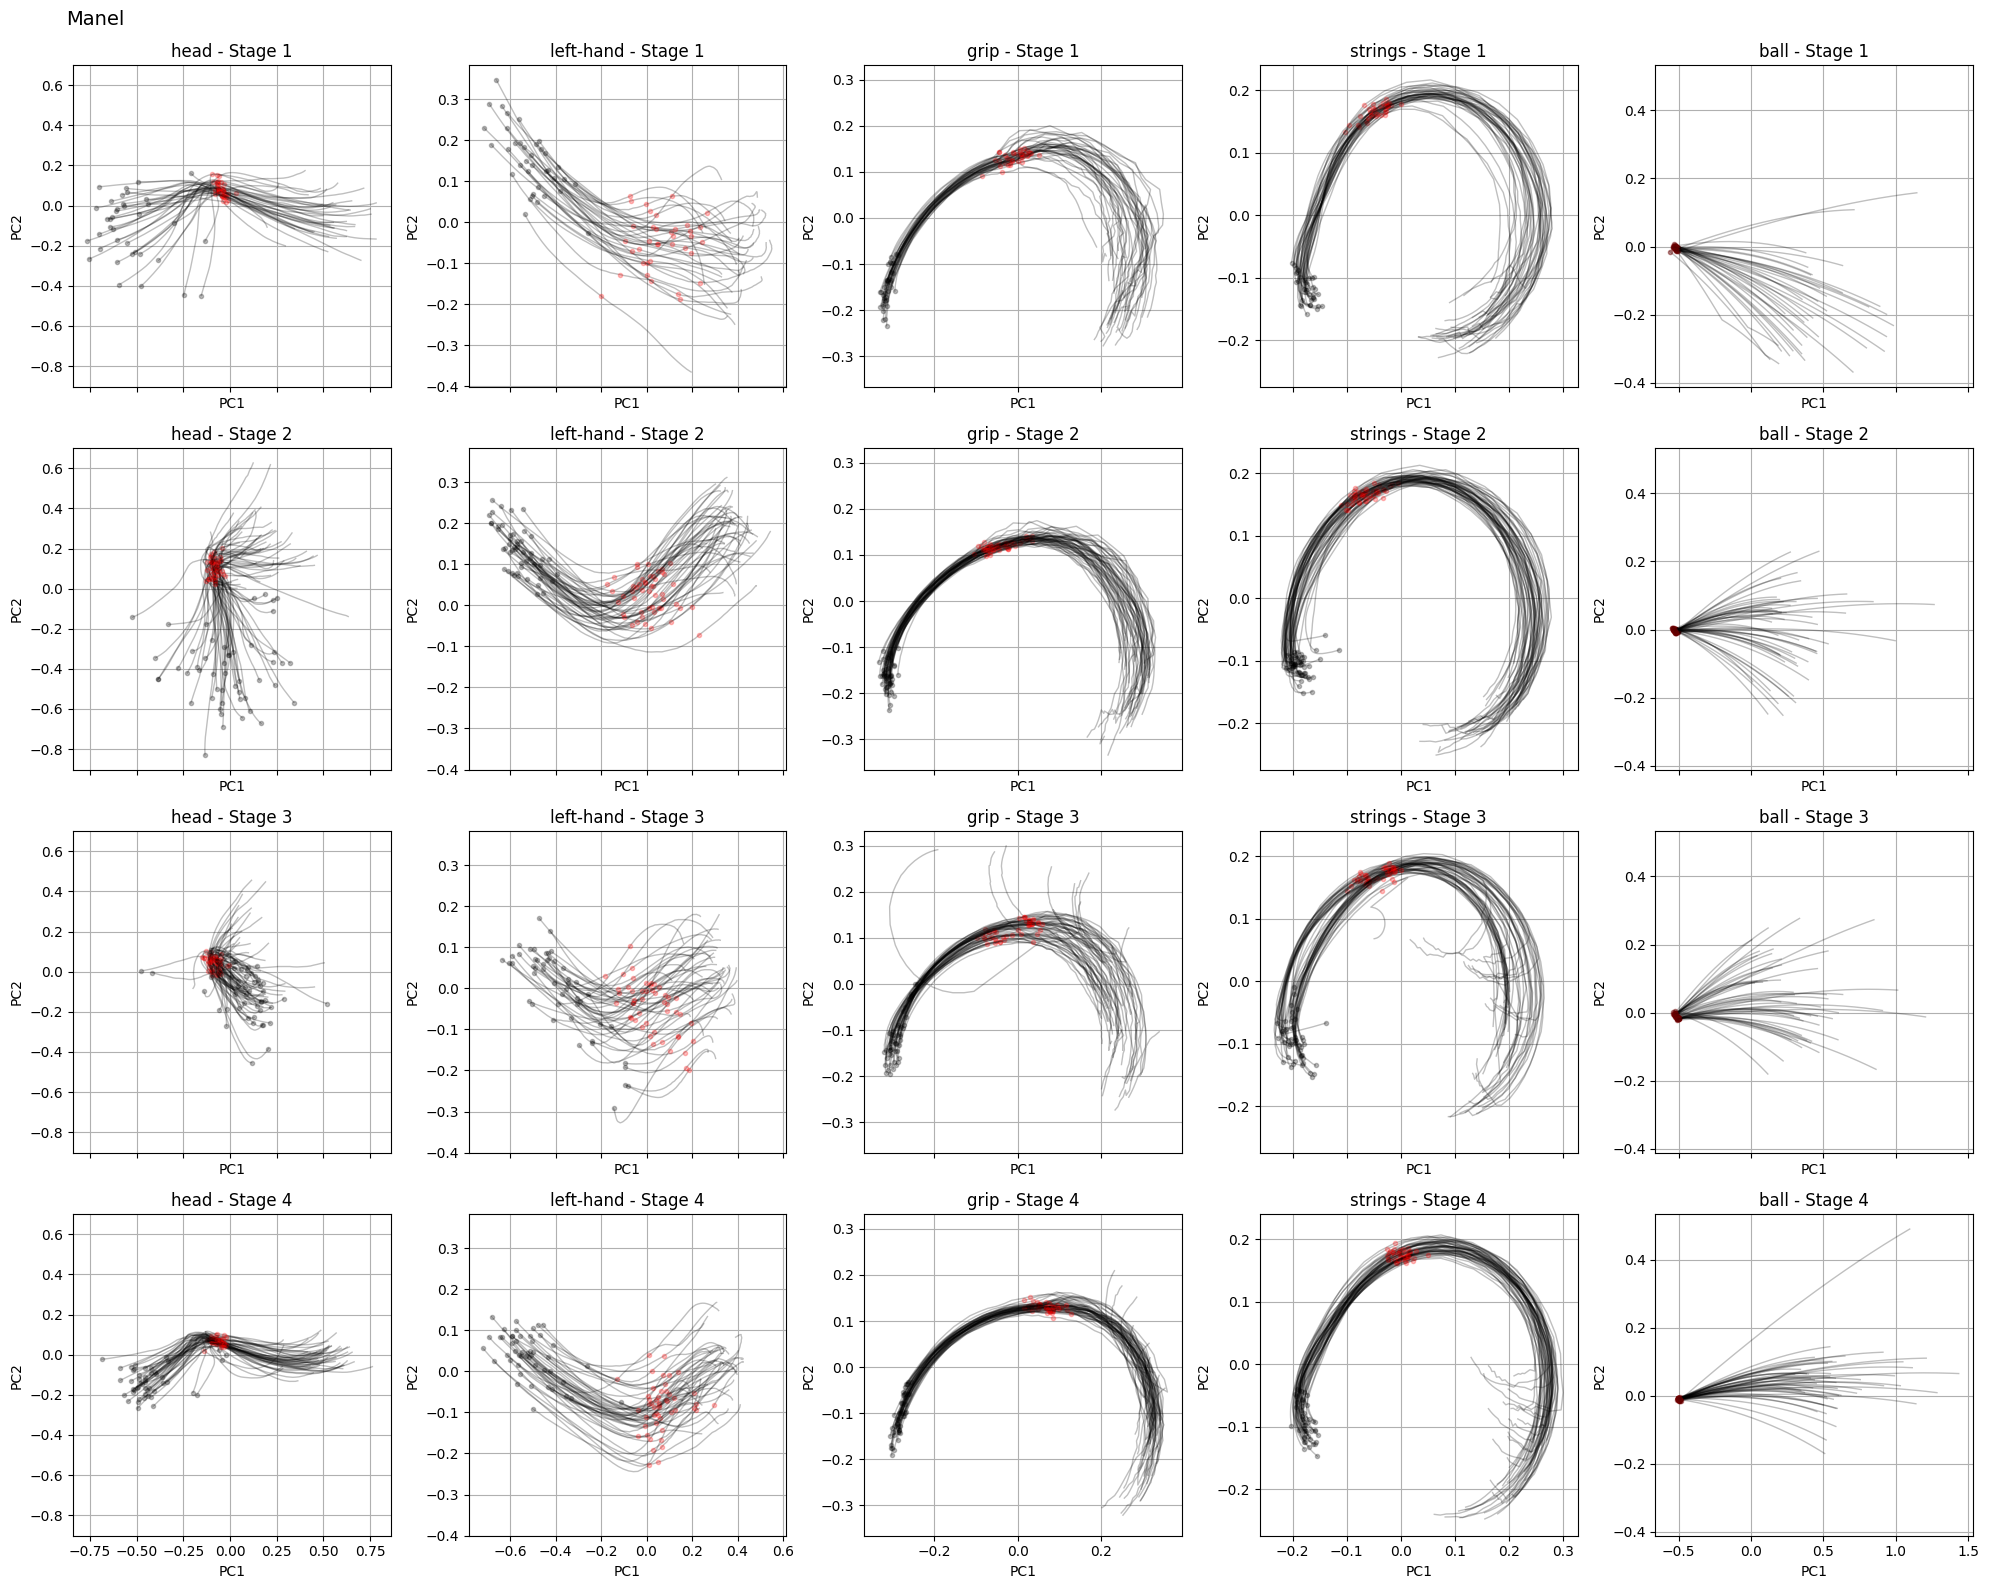

In [66]:
fig, axs = plt.subplots(
    num_stages,
    num_features,
    figsize=(4 * num_features, 4 * num_stages),
    sharex="col",
    sharey="col",
)
fig.suptitle(f"{subject2plot}", fontsize=14, x=0.05, y=0.99)

for stage_idx, stage in enumerate(unique_stages):
    for i, label in enumerate(features2compare_labels):
        df_traj = dfs_trajectories_pca[label]

        # Filter by stage
        df_stage = df_traj[df_traj["stage"] == stage]
        for _, row in df_stage.iterrows():
            traj_pc1 = np.array(row["x"])
            traj_pc2 = np.array(row["y"])
            if traj_pc1.shape[0] > 0 and traj_pc2.shape[0] > 0:
                axs[stage_idx, i].plot(
                    traj_pc1, traj_pc2, color="black", alpha=0.25, linewidth=1
                )
                
                # Mark the racket hit moment (center of window)
                hit_idx = np.abs(row["time"]).argmin()
                axs[stage_idx, i].plot(
                    traj_pc1[hit_idx],
                    traj_pc2[hit_idx],
                    color="red",
                    marker="o",
                    markersize=3,
                    alpha=0.25,
                    label="Racket Hit" if stage_idx == 0 and i == 0 else None,
                )

                # Mark the start of the trajectory
                axs[stage_idx, i].plot(
                    traj_pc1[0],
                    traj_pc2[0],
                    color="black",
                    alpha=0.25,
                    marker="o",
                    markersize=3,
                )
                
        axs[stage_idx, i].set_title(f"{label} - Stage {stage}")
        axs[stage_idx, i].set_xlabel("PC1")
        axs[stage_idx, i].set_ylabel("PC2")
        axs[stage_idx, i].grid()

plt.tight_layout()
plt.show()

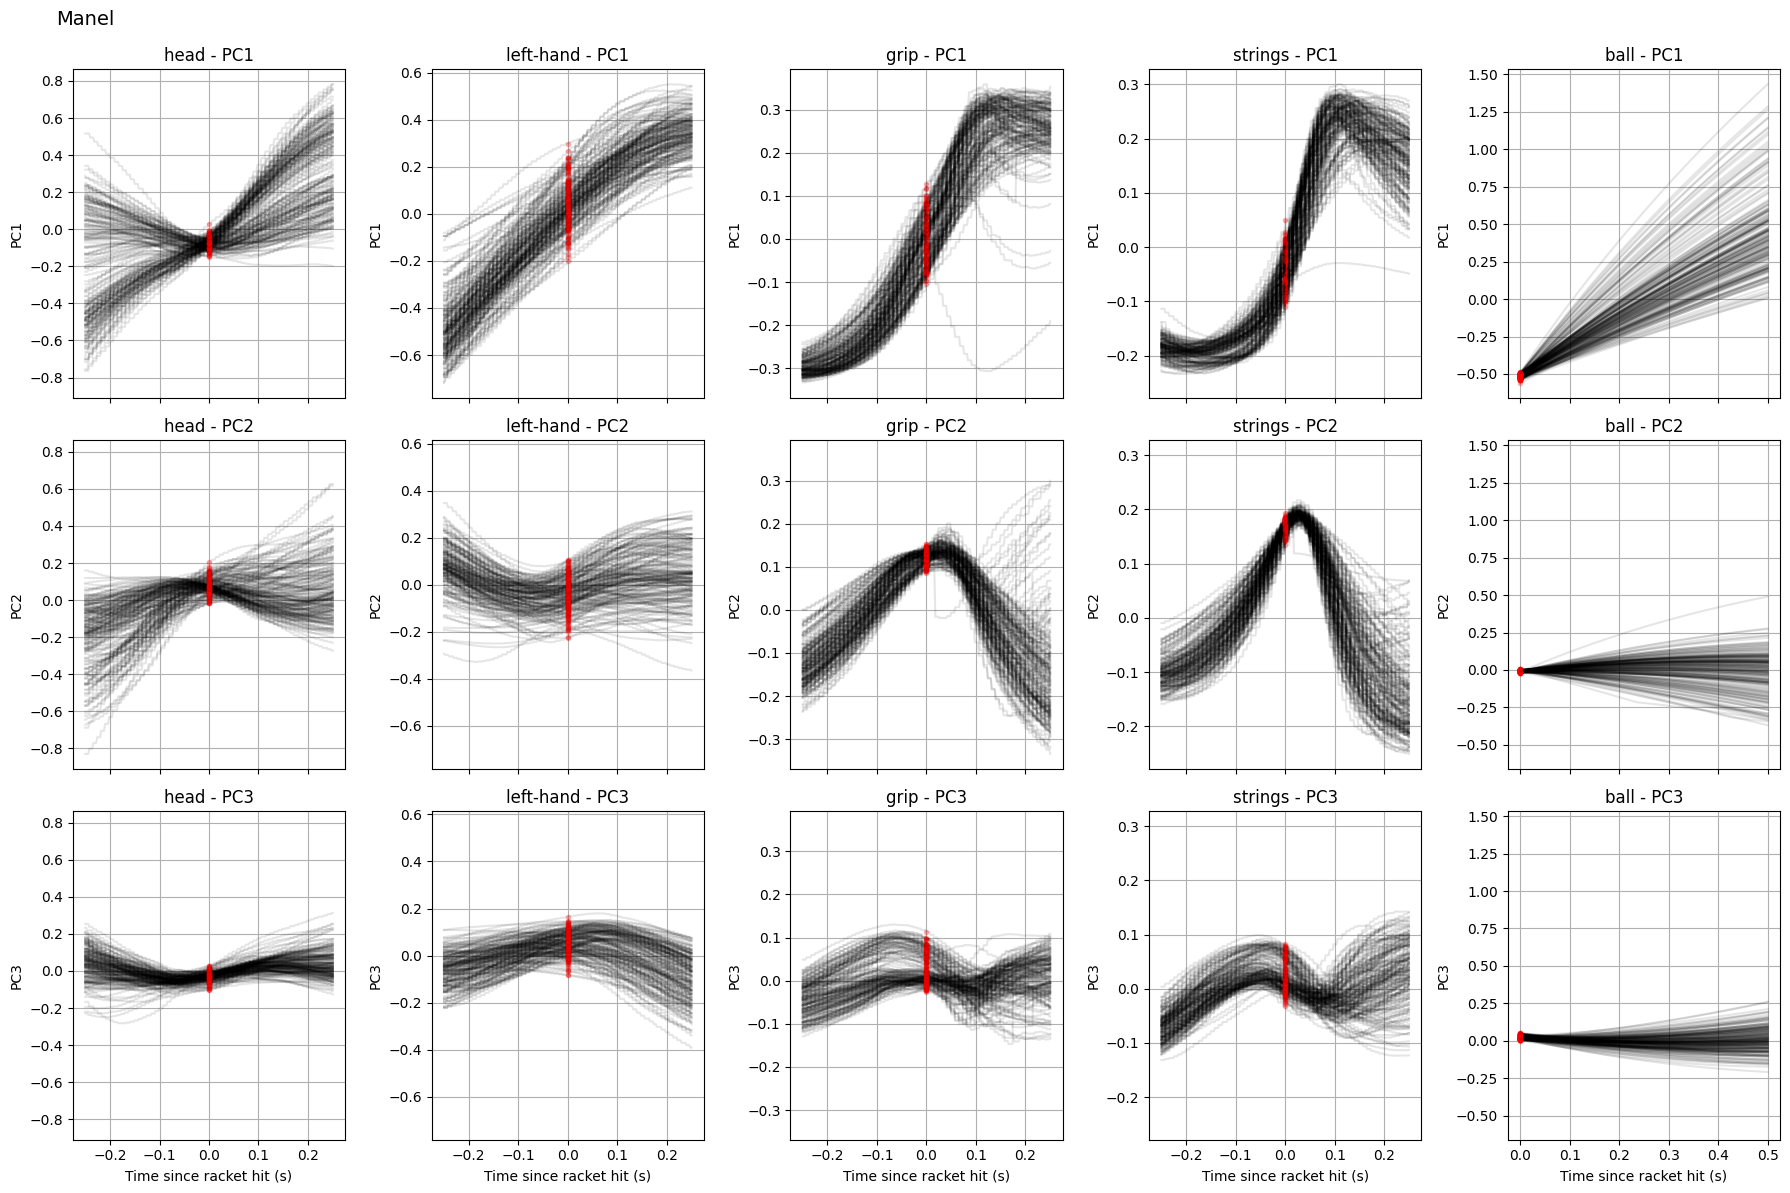

In [67]:
fig, axs = plt.subplots(3, num_features, figsize=(18, 12), sharex="col", sharey="col")
fig.suptitle(f"{subject2plot}", fontsize=14, x=0.05, y=0.99)

for i, label in enumerate(features2compare_labels):
    df_traj = dfs_trajectories_pca[label]

    aligned_pc1 = []
    aligned_pc2 = []
    aligned_pc3 = []
    aligned_times = []
    for _, row in df_traj.iterrows():
        traj_time = np.array(row["time"])
        traj_pc1 = np.array(row["x"])
        traj_pc2 = np.array(row["y"])
        traj_pc3 = np.array(row["z"])
        if traj_pc1.shape[0] > 0:
            aligned_pc1.append(traj_pc1)
            aligned_pc2.append(traj_pc2)
            aligned_pc3.append(traj_pc3)
            aligned_times.append(traj_time)

    # Plot PC1
    for traj_time, traj_pc1 in zip(aligned_times, aligned_pc1):
        axs[0, i].plot(traj_time, traj_pc1, color="black", alpha=0.1)
        hit_idx = np.abs(traj_time).argmin()
        axs[0, i].plot(traj_time[hit_idx], traj_pc1[hit_idx], "ro", markersize=3, alpha=.25)
    axs[0, i].set_title(f"{label} - PC1")
    axs[0, i].set_ylabel("PC1")
    axs[0, i].grid()

    # Plot PC2
    for traj_time, traj_pc2 in zip(aligned_times, aligned_pc2):
        axs[1, i].plot(traj_time, traj_pc2, color="black", alpha=0.1)
        hit_idx = np.abs(traj_time).argmin()
        axs[1, i].plot(traj_time[hit_idx], traj_pc2[hit_idx], "ro", markersize=3, alpha=.25)
    axs[1, i].set_title(f"{label} - PC2")
    axs[1, i].set_ylabel("PC2")
    axs[1, i].grid()

    # Plot PC3
    for traj_time, traj_pc3 in zip(aligned_times, aligned_pc3):
        axs[2, i].plot(traj_time, traj_pc3, color="black", alpha=0.1)
        hit_idx = np.abs(traj_time).argmin()
        axs[2, i].plot(traj_time[hit_idx], traj_pc3[hit_idx], "ro", markersize=3, alpha=.25)
    axs[2, i].set_title(f"{label} - PC3")
    axs[2, i].set_ylabel("PC3")
    axs[2, i].grid()

for i in range(num_features):
    axs[2, i].set_xlabel("Time since racket hit (s)")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(
    num_stages,
    num_features,
    figsize=(4 * num_features, 4 * num_stages),
    sharex="col",
    sharey=True,
)
fig.suptitle("Instantaneous 3D Trajectory Speeds (PCA space)", fontsize=16, y=0.98)

for stage_idx, stage in enumerate(unique_stages):
    for f_idx, label in enumerate(features2compare_labels):
        df_traj = dfs_trajectories_pca[label]
        df_stage = df_traj[df_traj["stage"] == stage]

        all_speeds = []
        all_times = []
        for trial_idx, row in enumerate(df_stage.itertuples()):
            traj_time = np.array(row.time)
            traj_xyz = np.column_stack([row.x, row.y, row.z])
            if traj_xyz.shape[0] < 2:
                continue
            dt = np.diff(traj_time)
            dpos = np.diff(traj_xyz, axis=0)
            speed = np.linalg.norm(dpos, axis=1) / dt
            axs[stage_idx, f_idx].plot(
                traj_time[1:],
                speed,
                color=feature_colors[f_idx],
                alpha=0.25,
                label=label if trial_idx == 0 else None,
            )
            all_speeds.append(speed)
            all_times.append(traj_time[1:])

        # Superimpose average speed
        if all_speeds:
            # Interpolate all speeds to a common time base for averaging
            min_len = min(map(len, all_speeds))
            speeds_stack = np.array([s[:min_len] for s in all_speeds])
            times_stack = np.array([t[:min_len] for t in all_times])
            avg_time = np.mean(times_stack, axis=0)
            avg_speed = np.mean(speeds_stack, axis=0)
            axs[stage_idx, f_idx].plot(
                avg_time,
                avg_speed,
                color="black",
                linewidth=2,
                label=f"{label} avg"
            )

        axs[stage_idx, f_idx].set_title(f"{label} - Stage {stage}")
        axs[stage_idx, f_idx].set_xlabel("Time (s)")
        axs[stage_idx, f_idx].set_ylabel("3D Speed (a.u.)")
        axs[stage_idx, f_idx].grid()
        axs[stage_idx, f_idx].set_ylim(0, 30)
        if stage_idx == 0 and f_idx == 0:
            axs[stage_idx, f_idx].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

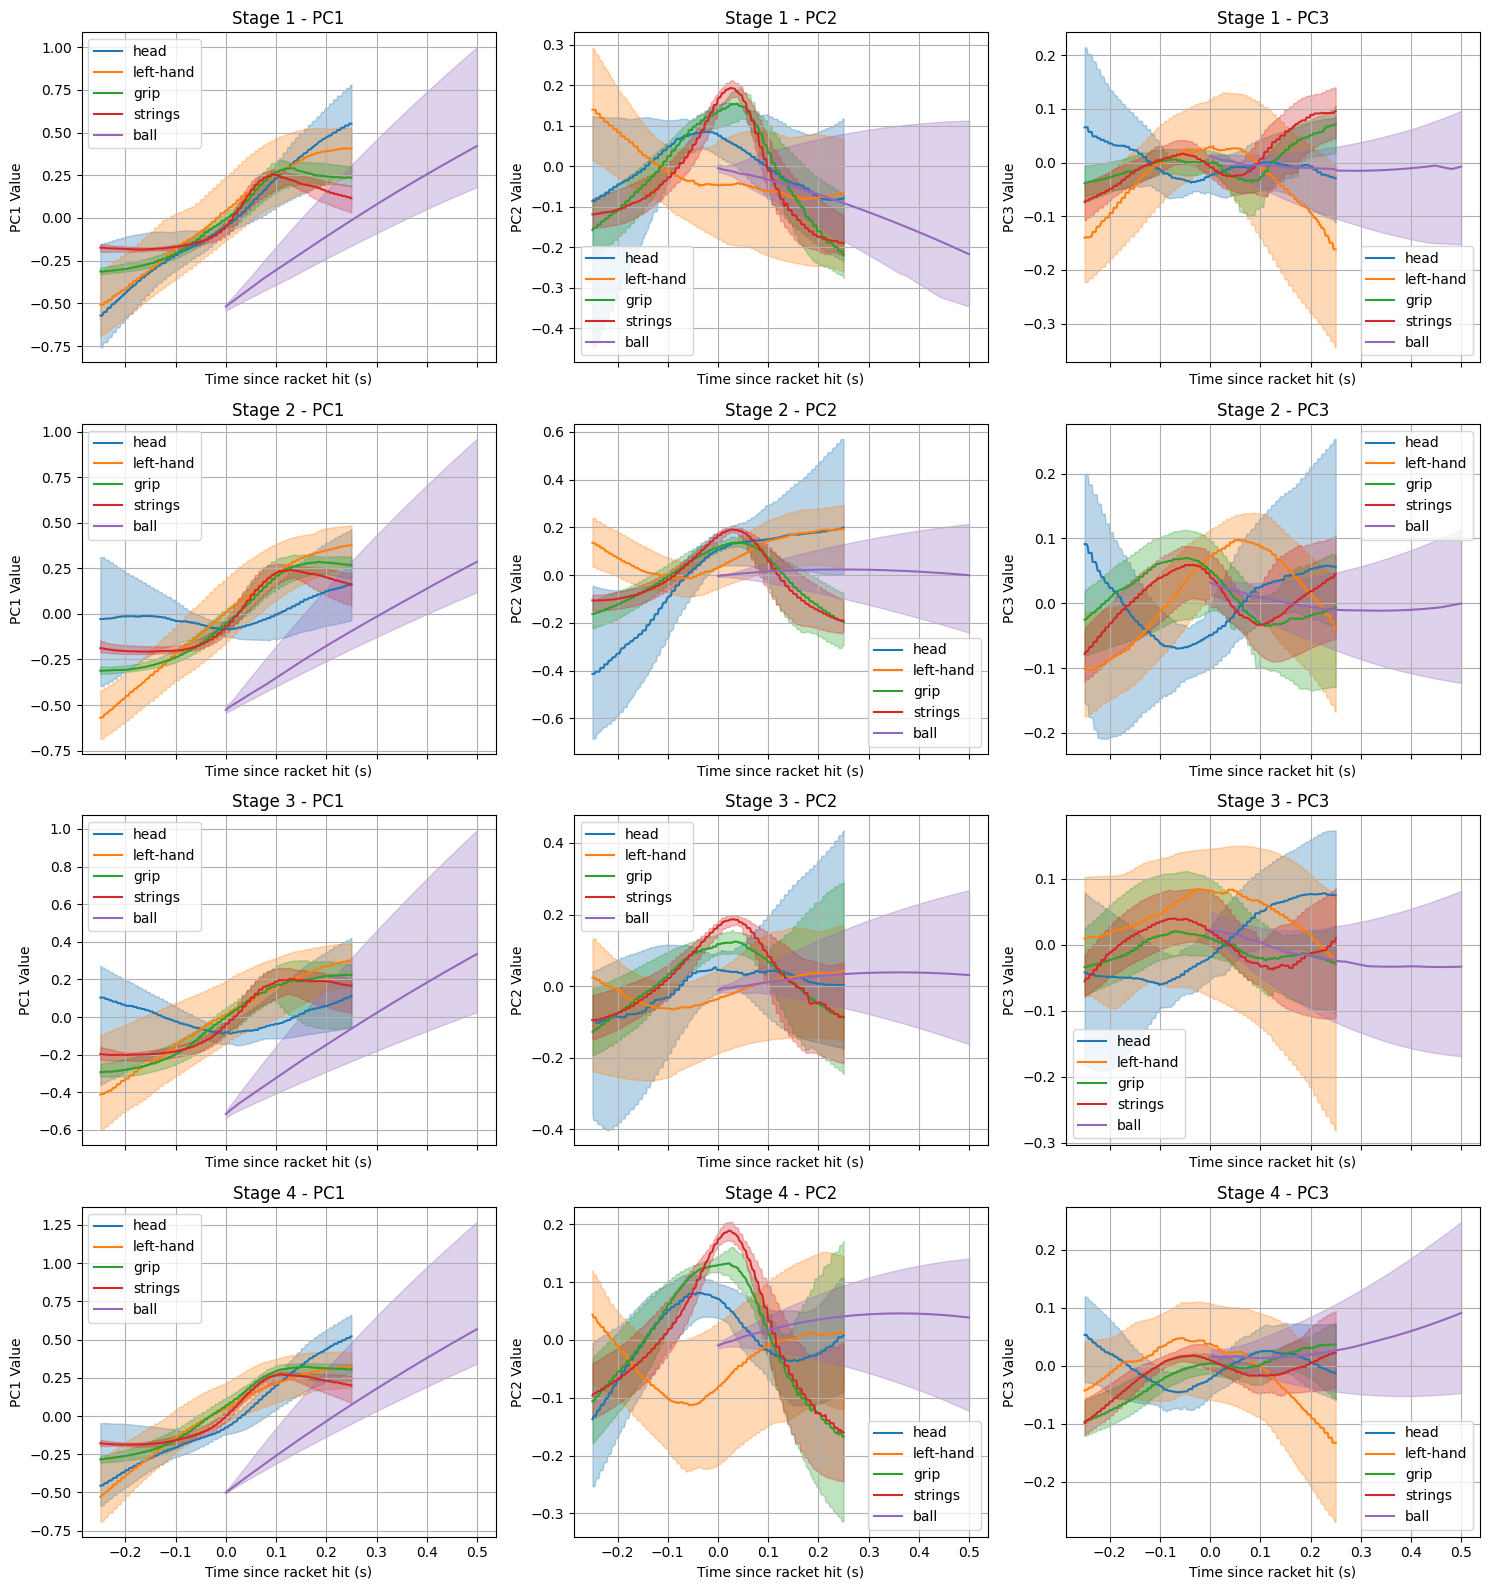

In [69]:
lower_percentile = 2.5
upper_percentile = 97.5

fig, axs = plt.subplots(
    num_stages, 3, figsize=(15, 4 * num_stages), sharex="col", sharey=False
)

for stage_idx, stage in enumerate(unique_stages):
    for f_idx, label in enumerate(features2compare_labels):
        df_traj = dfs_trajectories_pca[label]

        # Filter by stage
        df_stage = df_traj[df_traj["stage"] == stage]

        aligned_pc1 = []
        aligned_pc2 = []
        aligned_pc3 = []
        for _, row in df_stage.iterrows():
            traj_time = np.array(row["time"])
            traj_pc1 = np.array(row["x"])
            traj_pc2 = np.array(row["y"])
            traj_pc3 = np.array(row["z"])
            if traj_pc1.shape[0] == window_size:
                aligned_pc1.append(traj_pc1)
                aligned_pc2.append(traj_pc2)
                aligned_pc3.append(traj_pc3)

        aligned_pc1 = np.array(aligned_pc1)
        aligned_pc2 = np.array(aligned_pc2)
        aligned_pc3 = np.array(aligned_pc3)

        # PC1
        if aligned_pc1.shape[0] > 0:
            q1_pc1 = np.percentile(aligned_pc1, lower_percentile, axis=0)
            q3_pc1 = np.percentile(aligned_pc1, upper_percentile, axis=0)
            axs[stage_idx, 0].fill_between(
                traj_time, q1_pc1, q3_pc1, alpha=0.3, color=feature_colors[f_idx]
            )
            axs[stage_idx, 0].plot(
                traj_time,
                np.median(aligned_pc1, axis=0),
                color=feature_colors[f_idx],
                label=f"{label}",
            )

        # PC2
        if aligned_pc2.shape[0] > 0:
            q1_pc2 = np.percentile(aligned_pc2, lower_percentile, axis=0)
            q3_pc2 = np.percentile(aligned_pc2, upper_percentile, axis=0)
            axs[stage_idx, 1].fill_between(
                traj_time, q1_pc2, q3_pc2, alpha=0.3, color=feature_colors[f_idx]
            )
            axs[stage_idx, 1].plot(
                traj_time,
                np.median(aligned_pc2, axis=0),
                color=feature_colors[f_idx],
                label=f"{label}",
            )

        # PC3
        if aligned_pc3.shape[0] > 0:
            q1_pc3 = np.percentile(aligned_pc3, lower_percentile, axis=0)
            q3_pc3 = np.percentile(aligned_pc3, upper_percentile, axis=0)
            axs[stage_idx, 2].fill_between(
                traj_time, q1_pc3, q3_pc3, alpha=0.3, color=feature_colors[f_idx]
            )
            axs[stage_idx, 2].plot(
                traj_time,
                np.median(aligned_pc3, axis=0),
                color=feature_colors[f_idx],
                label=f"{label}",
            )

    axs[stage_idx, 0].set_title(f"Stage {stage} - PC1")
    axs[stage_idx, 0].set_xlabel("Time since racket hit (s)")
    axs[stage_idx, 0].set_ylabel("PC1 Value")
    axs[stage_idx, 0].legend()
    axs[stage_idx, 0].grid()

    axs[stage_idx, 1].set_title(f"Stage {stage} - PC2")
    axs[stage_idx, 1].set_xlabel("Time since racket hit (s)")
    axs[stage_idx, 1].set_ylabel("PC2 Value")
    axs[stage_idx, 1].legend()
    axs[stage_idx, 1].grid()

    axs[stage_idx, 2].set_title(f"Stage {stage} - PC3")
    axs[stage_idx, 2].set_xlabel("Time since racket hit (s)")
    axs[stage_idx, 2].set_ylabel("PC3 Value")
    axs[stage_idx, 2].legend()
    axs[stage_idx, 2].grid()

plt.tight_layout()
plt.show()

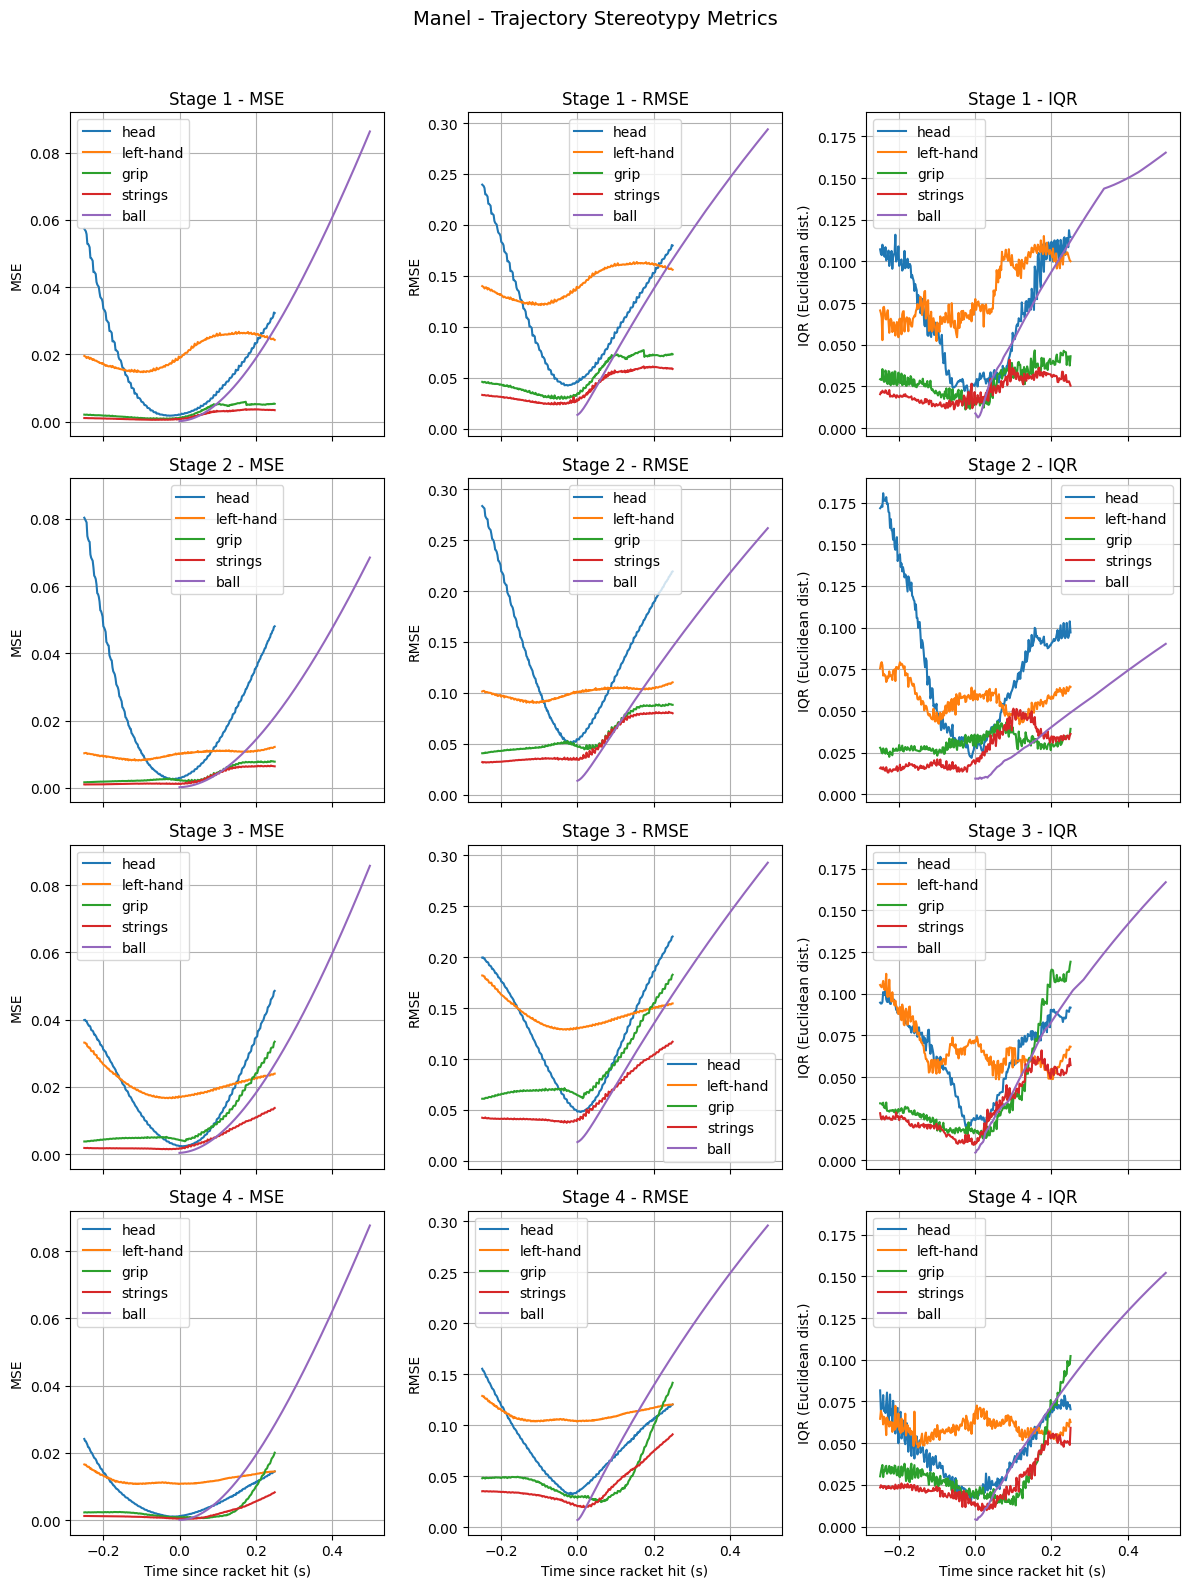

In [70]:
# Plot stereotypy metrics: MSE, RMSE, and IQR (no DTW) using dfs_trajectories_pca
fig, axs = plt.subplots(
    num_stages, 3, figsize=(12, 4 * num_stages), sharex=True, sharey="col"
)
fig.suptitle(
    f"{subject2plot} - Trajectory Stereotypy Metrics", fontsize=14, x=0.5, y=0.99
)

for stage_idx, stage in enumerate(unique_stages):
    for f_idx, label in enumerate(features2compare_labels):
        df_traj = dfs_trajectories_pca[label]

        # Filter by stage
        df_stage = df_traj[df_traj["stage"] == stage]

        aligned_trajs = []
        for _, row in df_stage.iterrows():
            traj = np.column_stack([row["x"], row["y"], row["z"]])
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)

        aligned_trajs = np.array(aligned_trajs)  # shape: (n_trials, window_size, 3)
        if aligned_trajs.shape[0] == 0:
            continue

        # Extract the time vector for the current stage
        traj_time = row["time"]

        # Mean trajectory
        mean_traj = np.mean(aligned_trajs, axis=0)  # (window_size, 3)

        # MSE: mean squared error to the mean trajectory at each time
        mse = np.mean(
            np.sum((aligned_trajs - mean_traj) ** 2, axis=2), axis=0
        )  # (window_size,)

        # RMSE: root mean squared error to the mean trajectory at each time
        rmse = np.sqrt(mse)  # (window_size,)

        # IQR: interquartile range of Euclidean distances to the mean trajectory at each time
        dists = np.linalg.norm(
            aligned_trajs - mean_traj, axis=2
        )  # (n_trials, window_size)
        iqr = np.percentile(dists, 75, axis=0) - np.percentile(dists, 25, axis=0)

        axs[stage_idx, 0].plot(traj_time, mse, color=feature_colors[f_idx], label=label)
        axs[stage_idx, 1].plot(
            traj_time, rmse, color=feature_colors[f_idx], label=label
        )
        axs[stage_idx, 2].plot(traj_time, iqr, color=feature_colors[f_idx], label=label)

    axs[stage_idx, 0].set_title(f"Stage {stage} - MSE")
    axs[stage_idx, 0].set_ylabel("MSE")
    axs[stage_idx, 0].legend()
    axs[stage_idx, 0].grid()

    axs[stage_idx, 1].set_title(f"Stage {stage} - RMSE")
    axs[stage_idx, 1].set_ylabel("RMSE")
    axs[stage_idx, 1].legend()
    axs[stage_idx, 1].grid()

    axs[stage_idx, 2].set_title(f"Stage {stage} - IQR")
    axs[stage_idx, 2].set_ylabel("IQR (Euclidean dist.)")
    axs[stage_idx, 2].legend()
    axs[stage_idx, 2].grid()

for ax in axs[-1, :]:
    ax.set_xlabel("Time since racket hit (s)")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Compute trajectory dissimilarity metrics

In [71]:
# Compute DTW and Procrustes distances between all pairs of aligned trajectories for each feature and stage
dtw_distances = []
procrustes_distances = []

# Iterate through each stage and feature to compute distances
for stage in unique_stages:
    for f_idx, label in enumerate(features2compare_labels):
        df_traj = dfs_trajectories_pca[label]

        # Filter by stage
        df_stage = df_traj[df_traj["stage"] == stage]

        # Collect aligned trajectories (PC1, PC2, PC3)
        aligned_trajs = []
        for _, row in df_stage.iterrows():
            traj = np.column_stack([row["x"], row["y"], row["z"]])
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)
        aligned_trajs = np.array(aligned_trajs)  # shape: (n_trials, window_size, 3)

        if aligned_trajs.shape[0] < 2:
            continue

        # Compute distances for all unique pairs and store in DataFrames
        for idx1, idx2 in combinations(range(len(aligned_trajs)), 2):
            
            # DTW distance
            distance_dtw, _ = fastdtw(
                aligned_trajs[idx1], aligned_trajs[idx2], dist=euclidean
            )
            dtw_distances.append({
                "stage": stage,
                "feature": label,
                "trial1": idx1,
                "trial2": idx2,
                "distance": distance_dtw,
            })

            # Procrustes distance
            _, _, disparity = procrustes(aligned_trajs[idx1], aligned_trajs[idx2])
            procrustes_distances.append({
                "stage": stage,
                "feature": label,
                "trial1": idx1,
                "trial2": idx2,
                "distance": disparity,
            })

# Convert the lists of distances to DataFrames
dtw_distances_df = pd.DataFrame(dtw_distances)
procrustes_distances_df = pd.DataFrame(procrustes_distances)


KeyboardInterrupt: 

### Plot DTW distance distributions

In [ ]:
fig, axs = plt.subplots(
    num_stages,
    num_features,
    figsize=(4 * num_features, 4 * num_stages),
    sharex=False,
    sharey="col",
)
fig.suptitle("DTW Distance Distributions per Feature and Stage", fontsize=16, y=0.98)

num_bins = 50  # Number of bins for histogram
bins = np.linspace(0, 1, num_bins + 1)  # Adjust range as needed

for stage_idx, stage in enumerate(unique_stages):
    for f_idx, label in enumerate(features2compare_labels):

        # Filter DTW distances for this stage and feature
        mask = (dtw_distances_df["stage"] == stage) & (
            dtw_distances_df["feature"] == label
        )
        dtw_vals = dtw_distances_df.loc[mask, "distance"].values

        if len(dtw_vals) > 0:
            axs[stage_idx, f_idx].hist(
                dtw_vals, bins=bins, color=feature_colors[f_idx], alpha=0.7
            )
        axs[stage_idx, f_idx].set_title(f"{label} - Stage {stage}")
        axs[stage_idx, f_idx].set_xlabel("DTW Distance")
        axs[stage_idx, f_idx].set_ylabel("Count")
        axs[stage_idx, f_idx].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
fig, axs = plt.subplots(
    len(unique_stages), 2,
    figsize=(10, 4 * len(unique_stages)),
    sharex="col", sharey=True
)
fig.suptitle("CDFs of DTW and Procrustes Distances per Stage", fontsize=16, y=0.98)

for stage_idx, stage in enumerate(unique_stages):
    for f_idx, label in enumerate(features2compare_labels):

        # DTW CDF
        mask_dtw = (dtw_distances_df["stage"] == stage) & (dtw_distances_df["feature"] == label)
        dtw_vals = dtw_distances_df.loc[mask_dtw, "distance"].values
        if len(dtw_vals) > 0:
            sorted_dtw = np.sort(dtw_vals)
            cdf_dtw = np.arange(1, len(sorted_dtw) + 1) / len(sorted_dtw)
            axs[stage_idx, 0].plot(sorted_dtw, cdf_dtw, color=feature_colors[f_idx], label=label)

        # Procrustes CDF
        mask_proc = (procrustes_distances_df["stage"] == stage) & (procrustes_distances_df["feature"] == label)
        proc_vals = procrustes_distances_df.loc[mask_proc, "distance"].values
        if len(proc_vals) > 0:
            sorted_proc = np.sort(proc_vals)
            cdf_proc = np.arange(1, len(sorted_proc) + 1) / len(sorted_proc)
            axs[stage_idx, 1].plot(sorted_proc, cdf_proc, color=feature_colors[f_idx], label=label)

    axs[stage_idx, 0].set_title(f"Stage {stage} - DTW CDF")
    axs[stage_idx, 0].set_xlabel("DTW Distance")
    axs[stage_idx, 0].set_ylabel("CDF")
    axs[stage_idx, 0].set_xlim([0, .5])
    axs[stage_idx, 0].legend()
    axs[stage_idx, 0].grid()

    axs[stage_idx, 1].set_title(f"Stage {stage} - Procrustes CDF")
    axs[stage_idx, 1].set_xlabel("Procrustes Distance")
    axs[stage_idx, 1].set_ylabel("CDF")
    axs[stage_idx, 1].set_xlim([0, .5])
    axs[stage_idx, 1].legend()
    axs[stage_idx, 1].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
fig, axs = plt.subplots(
    num_stages, 2, figsize=(10, 4 * num_stages), sharex="col", sharey="row"
)
fig.suptitle(
    f"{subject2plot}: CDFs of Procrustes and DTW Distances", fontsize=14, y=0.98
)

for stage in range(1, num_stages + 1):
    for f_idx, label in enumerate(features2compare_labels):
        df_feat = dfs_features[label]
        df_stage = df_feat[df_feat["stage"] == stage]
        alignment_times = df_stage[df_stage["event"] == alignment]["time"].values

        aligned_trajs = []
        for t_align in alignment_times:
            traj = df_stage[
                (df_stage["time"] >= t_align - half_window_duration)
                & (df_stage["time"] <= t_align + half_window_duration)
            ][["position.x", "position.y", "position.z"]].to_numpy()
            if traj.shape[0] == window_size:
                aligned_trajs.append(traj)
        aligned_trajs = np.array(aligned_trajs)

        if aligned_trajs.shape[0] == 0:
            continue

        mean_traj = np.mean(aligned_trajs, axis=0)

        # Procrustes distances
        procrustes_distances = []
        for traj in aligned_trajs:
            _, _, disparity = procrustes(mean_traj, traj)
            procrustes_distances.append(disparity)
        procrustes_distances = np.array(procrustes_distances)
        sorted_procrustes = np.sort(procrustes_distances)
        cdf_procrustes = np.arange(1, len(sorted_procrustes) + 1) / len(
            sorted_procrustes
        )
        axs[stage - 1, 0].plot(
            sorted_procrustes, cdf_procrustes, label=label, color=feature_colors[f_idx]
        )

        # DTW distances
        dtw_distances = []
        for traj in aligned_trajs:
            distance, _ = fastdtw(traj, mean_traj, dist=euclidean)
            dtw_distances.append(distance)
        dtw_distances = np.array(dtw_distances)
        sorted_dtw = np.sort(dtw_distances)
        cdf_dtw = np.arange(1, len(sorted_dtw) + 1) / len(sorted_dtw)
        axs[stage - 1, 1].plot(
            sorted_dtw, cdf_dtw, label=label, color=feature_colors[f_idx]
        )

    axs[stage - 1, 0].set_title(f"Stage {stage} - Procrustes CDF")
    axs[stage - 1, 0].set_xlabel("Procrustes Distance")
    axs[stage - 1, 0].set_ylabel("Cumulative Frequency")
    axs[stage - 1, 0].legend()
    axs[stage - 1, 0].grid()
    axs[stage - 1, 0].set_xlim([0, 0.05])

    axs[stage - 1, 1].set_title(f"Stage {stage} - DTW CDF")
    axs[stage - 1, 1].set_xlabel("DTW Distance")
    axs[stage - 1, 1].set_ylabel("Cumulative Frequency")
    axs[stage - 1, 1].legend()
    axs[stage - 1, 1].grid()
    axs[stage - 1, 1].set_xlim([0, .5])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()